### Jose Mijangos<br>Kirk Worley<br>Victoria Zamora<br>CST 463<br>Oct 17, 2018
# Predicting If Individuals Will Default on Payments Next Month
## Introduction
After a client defaults on credit card debt, the bank usually closes the clients card and sells their account to a collections agency for less than what is owed. The client will now owe their debt to the agency and can be sued for not complying. Hence, defaulting on credit card debt is very serious because both the client and the bank suffer financially when this occurs.  

Our motivation is to develop a classifier that will predict whether a consumer will default on credit card debt by performing analyses to determine which features are the best predictors of defaulting. While the true probability of defaulting is unknown, from a risk management perspective, being able to achieve a high recall and accuracy on predictions of defaulting allows banks to drastically cut losses and act accordingly with clients. The power of prediction helps mitigate damages due to clients consistently not fulfilling their obligations to their debts.

## Imported Modules

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, make_scorer, recall_score, accuracy_score
from sklearn.utils.fixes import signature
import warnings
warnings.filterwarnings('ignore')
sns.set(style='darkgrid')
np.random.seed(33928)

## Load Data

In [229]:
dat = pd.read_csv('C:/Users/josem/Desktop/default_cc_train.csv')

## Exploration

### Basic/Standard Info of Dataset

The title of the dataset is 'Default of Credit Card Clients'. We obtained this data from UCI Machine Learning Repository. The data was donated January 26, 2016. We accessed this data on October 13, 2018. This dataset has a total of 25,000 rows and 25 columns. We checked for NA values; there were none.



### Distribution of Clients who Default

Our goal is to predict whether a client defaults or not, so how many clients from this dataset actually defaulted?
According to the barplot below, approximately 78% of clients did not default and approximately 22% did default.

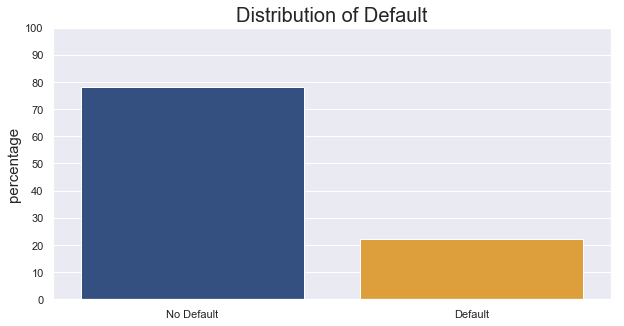

In [3]:
plt.figure(figsize=(10,5))
pal = ["#284d8c","#f7a520"]
ax = sns.barplot(x="default.payment.next.month", y="default.payment.next.month", data=dat, palette=pal, estimator=lambda x: len(x) / len(dat) * 100)
ax.set_yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
ax.set_xticklabels(["No Default","Default"])
plt.title("Distribution of Default", fontsize=20)
plt.ylabel("percentage", fontsize=15)
plt.xlabel("");

### Joint Plot of Credit Limit and Age for each Class

The older a person is, the more time he or she has to become financially stable. Hence, we were curious as to whether or not older people would have a higher credit limit. From the scatter plot below, it appears that credit limit slightly increases as age increases but for the most part the plot looks rather uniform across. However, those who default have a much higher credit limit than those who do not.



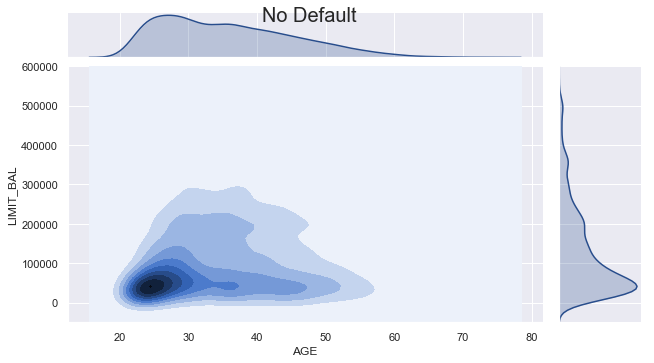

In [4]:
p1 = sns.jointplot(x="AGE", y="LIMIT_BAL", data=dat.loc[dat["default.payment.next.month"] == 1], color="#284d8c", 
                   kind='kde', ylim=[-50000,600000])
p1.fig.suptitle('No Default', fontsize=20)
p1.fig.set_figwidth(10)
p1.fig.set_figheight(5);

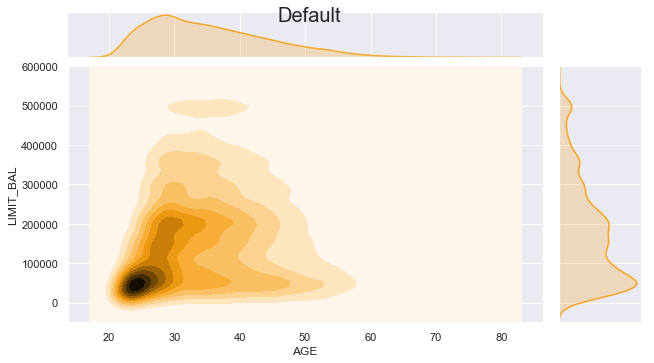

In [5]:
p2 = sns.jointplot(x="AGE", y="LIMIT_BAL", data=dat.loc[dat["default.payment.next.month"] == 0], color="#f7a520",
                   kind="kde", ylim=[-50000,600000])
p2.fig.set_figwidth(10)
p2.fig.set_figheight(5)
p2.fig.suptitle('Default', fontsize=20);

### Distribution of Age for each Class

Next, we examined the age distribution of clients by default and no default. Roughly 99% of the clients are between the ages of 20 and 80. Although there is a slight hump in the distribution for those who defaulted, both distributions seem to be unimodal. About 5% of those who did not default are 27-28 while 4.4% of those who default are 25-26. Also, between the ages of 26 and 41, more clients do not default. From ages 18 to 24, slightly more clients default than not. While ages 41-62 also have a slightly higher percentage of those who default compared to those who do not.

### Distribution of Credit Limit for each Class

From the density plot below, roughly estimating, we can see that once a client's credit limit surpasses 120,000, there is a higher probability that he or she defaults. On the other hand, there is a much higher percentage of not defaulting for clients with credit limit under 120,000. 


### Distribution of Clients who Default by Marital Status

Is marital status possibly a good predictor? Below, we show the percentage of clients who did default and clients who did not by their marital status. Of those that are married, over half of them did indeed default. Of those that are single, a higher percentage did not default. Overall however, single clients had a slightly  higher percentage of defaulting than married clients. Although the difference was not large enough to be significant, one theory we had to explain the difference was that married clients may have their spouse/partner help pay off credit card debt.

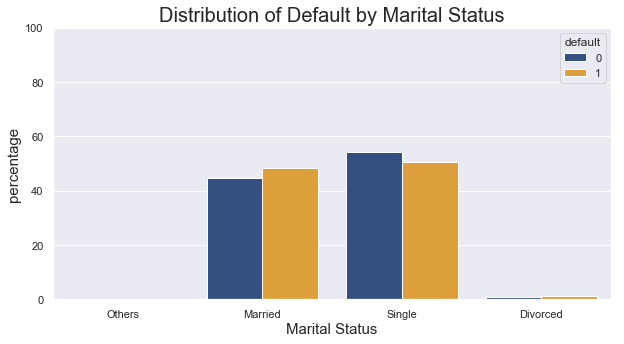

In [8]:
plt.figure(figsize=(10,5))
counts = (dat.groupby(['default.payment.next.month'])['MARRIAGE']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

ax = sns.barplot(x="MARRIAGE", y="percentage", hue="default.payment.next.month", data=counts, palette=pal)
ax.set_xticklabels(["Others","Married","Single","Divorced"])
plt.title("Distribution of Default by Marital Status", fontsize=20)
plt.ylim((0, 100))
plt.ylabel("percentage", fontsize=15)
plt.xlabel("Marital Status", fontsize=15)
plt.legend(title="default");

### Distribution of Clients who Default by Education

Failing to find significance of default by marital status, we moved on to default by education level. For both those who graduated from a university and those who graduated from high school, we see that a higher percentage defaulted than not. While for those who graduated from graduate school had a higher percentage of not defaulting- which makes sense. If a client finished graduate school, we assume he or she has a much higher pay than university and high school graduates. This also means her or she has more money to make payments toward their credit card bills.

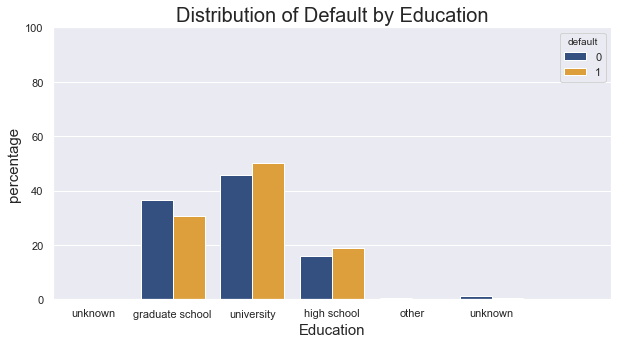

In [7]:
plt.figure(figsize=(10,5))
counts = (dat.groupby(['default.payment.next.month'])['EDUCATION']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

ax = sns.barplot(x="EDUCATION", y="percentage", hue="default.payment.next.month", data=counts, palette=pal)
ax.set_xticklabels(["unknown","graduate school","university","high school", "other", "unknown"])
plt.title("Distribution of Default by Education", fontsize=20)
plt.ylabel("percentage", fontsize=15)
plt.xlabel("Education", fontsize=15)
plt.ylim((0, 100))
plt.legend(title="default");

### Distribution of Default by Sex

What about gender? Are women more fiscally responsible than men or vice versa? From the barplot below, we see a higher percentage of females defaulted than males, but we believe this is because there are 1.5 times more females than males in the dataset. More males defaulted than males who did not default. While more women did not default compared those women who did.

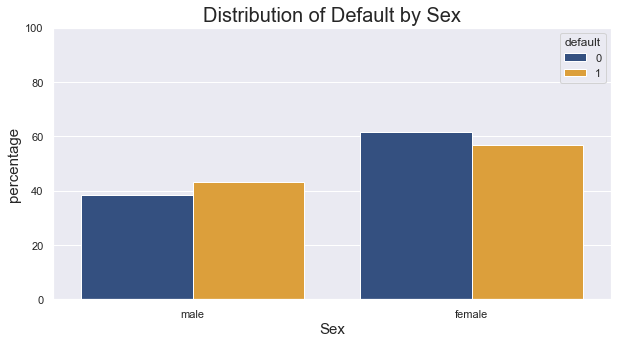

In [9]:
plt.figure(figsize=(10,5))
counts = (dat.groupby(['default.payment.next.month'])['SEX']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index())

ax = sns.barplot(x="SEX", y="percentage", hue="default.payment.next.month", data=counts, palette=pal)
plt.title("Distribution of Default by Sex", fontsize=20)
plt.ylim((0, 100))
plt.ylabel("percentage", fontsize=15)
plt.xlabel("Sex", fontsize=15)
ax.set_xticklabels(["male","female"])
plt.legend(title="default");

## Time Series Analysis
The data set contains recordings of clients bill and pay amount that were taken at regular one month intervals for a six month period of time. We can use these features to analyse temporal trends associated with clients monthly bill and pay amount.
### Convert Wide Data to Long Data
Currently within the data, every period of time has its own column. For convenience we will need to transform the structure of the data so that there is only one column for time and one column for the target value.

In [10]:
no_default_wide = dat.loc[dat["default.payment.next.month"] == 0]
default_wide = dat.loc[dat["default.payment.next.month"] == 1]

bill_no_default = no_default_wide[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]]
bill_no_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
bill_no_default = pd.melt(bill_no_default, var_name="month", value_name="bill")

bill_default = default_wide[["BILL_AMT1", "BILL_AMT2", "BILL_AMT3", "BILL_AMT4", "BILL_AMT5", "BILL_AMT6"]]
bill_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
bill_default = pd.melt(bill_default, var_name="month", value_name="bill")

### Create Time Series to compare Positive and Negative Classes
For our purposes, we are interested in comparing the time series of clients who do not default with clients who do default on their credit card payment. We can compare a single feature at a time or compare how multiple features interact with each other for each class. The code below derives features by dividing pay by bill and multiplying bill by pay. We specifically choose to divide bill by pay to represent what percent of the bill the client pays.

In [11]:
pay_no_default = no_default_wide[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]]
pay_no_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
pay_no_default = pd.melt(pay_no_default, var_name="month", value_name="pay")

pay_default = default_wide[["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]]
pay_default.columns = ["April", "May", "June", "July", "Aug", "Sept"]
pay_default = pd.melt(pay_default, var_name="month", value_name="pay")

div_no_default = pd.concat([bill_no_default["month"], pay_no_default["pay"] / (.001 + bill_no_default["bill"])], axis=1)
div_no_default.columns = ["month", "pay/bill"]

div_default = pd.concat([bill_default["month"], pay_default["pay"] / (.001 + bill_default["bill"])], axis=1)
div_default.columns = ["month", "pay/bill"]

rec_no_default = pd.concat([bill_no_default["month"], bill_no_default["bill"] / (.001 + pay_no_default["pay"])], axis=1)
rec_no_default.columns = ["month", "bill/pay"]

rec_default = pd.concat([bill_default["month"], bill_default["bill"] / (.001 + pay_default["pay"])], axis=1)
rec_default.columns = ["month", "bill/pay"]

prod_no_default = pd.concat([bill_no_default["month"], bill_no_default["bill"] * pay_no_default["pay"]], axis=1)
prod_no_default.columns = ["month", "bill*pay"]

prod_default = pd.concat([bill_default["month"], bill_default["bill"] * pay_default["pay"]], axis=1)
prod_default.columns = ["month", "bill*pay"]

### Bill Time Series by Class
Both classes have bill time series that are generally decreasing. However, the rate of decrease is greater for clients that do not default on their credit card payment. Unlike the negative class, the median bill amount for the positive class remains constant over time.

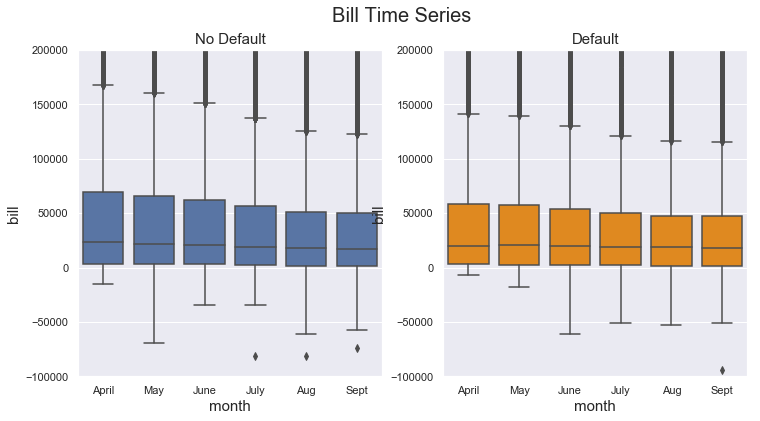

In [21]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylim((-100000, 200000))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylim((-100000, 200000))
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="bill", data=bill_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="bill", data=bill_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Bill Time Series', fontsize=20);

### Pay Time Series by Class
The pay time series for each class is again decreasing. On average, clients that do not default on credit card debt pay more each month than clients that do default on credit card debt. Also note that clients that do not default are unlikely to make payments less than about five-hundred dollars.

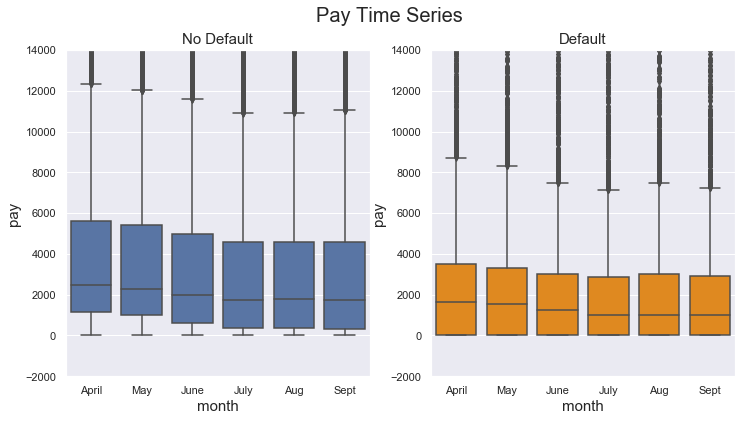

In [15]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylim((-2000, 14000))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylim((-2000, 14000))
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="pay", data=pay_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="pay", data=pay_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Pay Time Series', fontsize=20);

### Pay divided by Bill Time Series
The time series become very distinct when comparing the percent of bill paid for the positive and negative classes. It is rare for someone to pay more than fifthteen percent of their bill given that person belongs to the positive class. It is also rare for someone in the positive class to have a negative percent of bill paid. This suggests that for the positive class, if the bill is negative, then the client usually does not make a large payment.

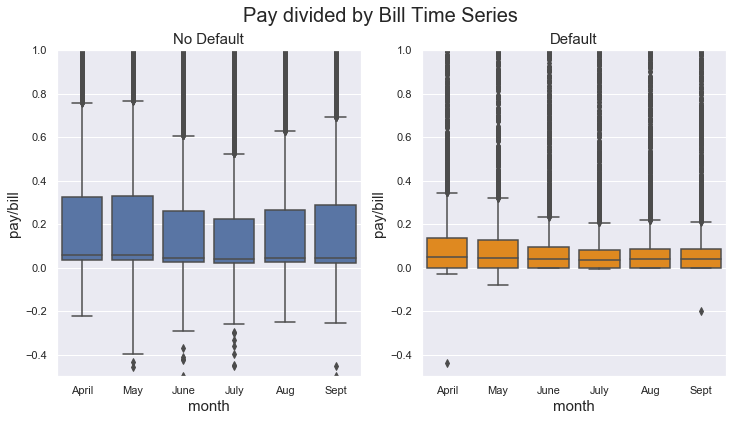

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12,6))
ax[0].set_ylim((-.5, 1))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylim((-.5, 1))
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="pay/bill", data=div_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="pay/bill", data=div_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Pay divided by Bill Time Series', fontsize=20);

### Bill times Pay Time Series
The product of bill and pay amount is less interpretable but the difference in the produced time series is prevalent. The time series for the negative class has greater variance than the negative class and decreases at a much faster rate.

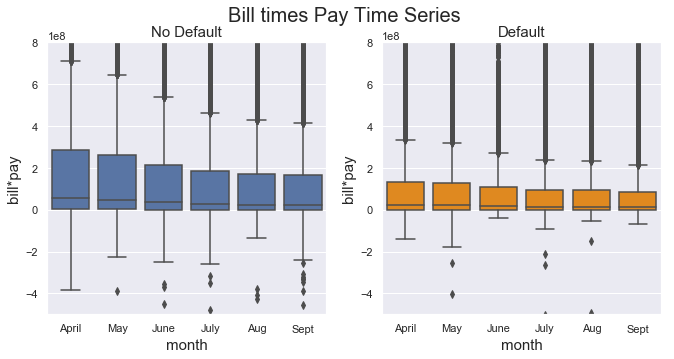

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(11,5))
ax[0].set_ylabel("", fontsize=15)
ax[0].set_xlabel("", fontsize=15)
ax[0].set_ylim((-500000000, 800000000))
ax[0].set_title("No Default", fontsize=15)
ax[1].set_ylabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[1].set_ylim((-500000000, 800000000))
ax[1].set_title("Default", fontsize=15)
sns.catplot("month", y="bill*pay", data=prod_no_default, kind="box", color="b", ax=ax[0])
plt.close()
sns.catplot("month", y="bill*pay", data=prod_default, kind="box", color="darkorange", ax=ax[1])
plt.close()
fig.suptitle('Bill times Pay Time Series', fontsize=20);

## Utilizing the Time Series Data as a Linear Component
Since we have columns which represent time series data over the course of 6 months, we can use this in terms of a linear component by fitting that data to a linear model. As shown above, there appears to be either upward or downward trends in the data based on whether or not the client defaulted. If we fit a linear model to each clients `BILL_AMT` and `PAY_AMT` over the six month period, we can use the coefficients of the linear model as predictors, since these would indicate either an upward or downward trend and perhaps help us determine if the client will default in the future. To fit a line to these points, we will use the numbers 1 - 6 for the months, and the actual bill or pay amount as the y values. We will utilize Numpy's polyfit function, which gives us the coefficients associated with the line of best fit through the data. We will do this for each row.

In [230]:
months = [i for i in range(1,7)]

bill_amt_subset = dat.iloc[:,[12, 13, 14, 15, 16, 17]]
new_predictors = np.array([])

for index, row in bill_amt_subset.iterrows():
    fit = np.polyfit(months, row, 1)
    
    if new_predictors.size == 0:
        new_predictors = fit
    else:
        new_predictors = np.vstack([new_predictors, fit])
        
bill_amt_coeff = pd.DataFrame(new_predictors, columns=['bill_amt_b1', 'bill_amt_b0'])

Below is an example of what this new dataframe looks like. We will have another example for pay_amt below as well.

In [213]:
bill_amt_coeff.head(5)

,bill_amt_b1,bill_amt_b0
0,1238.285714,-2889.333333
1,-2575.485714,44870.200000
2,-3735.800000,35542.133333
3,27155.171429,-45460.266667
4,755.514286,34988.200000


In [231]:
pay_amt_subset = dat.iloc[:,[18, 19, 20, 21, 22, 23]]
new_predictors2 = np.array([])

for index, row in pay_amt_subset.iterrows():
    fit = np.polyfit(months, row, 1)
    
    if new_predictors2.size == 0:
        new_predictors2 = fit
    else:
        new_predictors2 = np.vstack([new_predictors2, fit])
        
pay_amt_coeff = pd.DataFrame(new_predictors2, columns=['pay_amt_b1', 'pay_amt_b0'])

In [215]:
pay_amt_coeff.head(5)

,pay_amt_b1,pay_amt_b0
0,1384.400000,-2652.400000
1,-731.971429,4374.066667
2,1911.342857,3010.133333
3,15597.914286,-5099.866667
4,194.285714,953.333333


Now that we have the coefficients, lets add them to the DataFrame. The last four column indexes (90-93) represent these new coefficients.

In [232]:
bill_amt_coeff.columns = [90, 91]
pay_amt_coeff.columns = [92, 93]
dat = pd.concat([dat, bill_amt_coeff, pay_amt_coeff], axis=1)

Also we derive features that summarize interactions between pay and bill amount with basic statistics.

In [233]:
dat["pay/bill_amt_mean"] = np.mean(pay_amt_subset.T) / (np.mean(bill_amt_subset.T) + 1)
dat["pay/bill_amt_sd"] = np.std(pay_amt_subset.T) / (np.std(bill_amt_subset.T) + 1)

dat["bill*pay_amt_mean"] = np.mean(pay_amt_subset.T) * np.mean(bill_amt_subset.T)
dat["bill*bill_amt_sd"] = np.mean(pay_amt_subset.T) * np.mean(bill_amt_subset.T)

With the feature derivation done, we can begin the preprocessing.

##  Data Preprocessing
We have to prepare the data by scaling numeric features and encoding categorical features before we begin applying machine learning methods.
### Custom Transformer
DataFrameSelector will be used to project the data and MultColumnLabelEncoder will be used for the encoding of categorical features.


In [234]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)

class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # list of column to encode
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        output = X.copy()        
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname, col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)        
        return output
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

### Preprocessing Pipeline
Our pipeline needs to know which features are numeric and which are categorical before it can be used.

In [236]:
dat.shape

(25000, 33)

In [32]:
num_features = dat.columns[[1,5,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32]]
cat_features = dat.columns[[2,3,4,6,7,8,9,10,11]]
class_labels = dat.columns[-1]

num_pipeline = Pipeline([
  ("selector", DataFrameSelector(num_features)),
  ("remove_nas", SimpleImputer(strategy="median")),
  ("z-scaling", StandardScaler())
])

cat_pipeline = Pipeline([
  ('selector', DataFrameSelector(cat_features)),
  ('labeler', MultiColumnLabelEncoder()),
  ('encoder', OneHotEncoder(sparse = False, categories='auto')),
])

### Prepare Data for Machine Learning
Now we store the preprocessed data in X and the class labels in y. Then we split the data for training and testing our machine learning methods.

In [225]:
X_save.shape
dat.shape

(25000, 25)

In [33]:
X = pd.DataFrame(np.concatenate((num_pipeline.fit_transform(dat), cat_pipeline.fit_transform(dat)), 1))
y = dat["default.payment.next.month"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=831)

## Principal Component Analysis
Currently our preprocessed data has ninety features. To better represent this data graphically we perform dimensionality reduction via principal component analysis. Our goal is to determine how separable the classes are within the data.

### Cumulative Explained Variance Ratio
The plot represents the amount of the total information in the data represented by a number of principal components. For our data set you would need twenty principal components to retain at least have ninety-five percent of the total information.

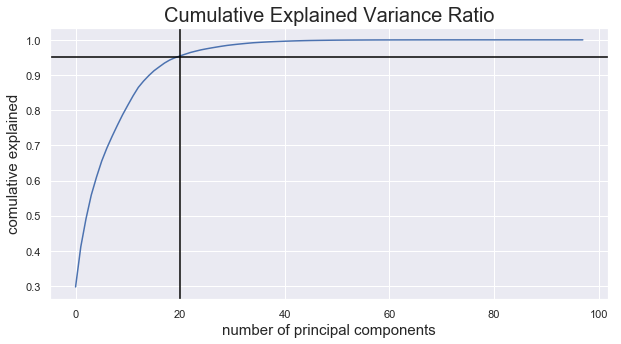

In [34]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum > 0.95)

plt.figure(figsize=(10,5))
sns.lineplot(data=cumsum)
plt.axvline(x=d, color = "black")
plt.axhline(y=.95, color = "black")
plt.xlabel('number of principal components', fontsize=15)
plt.ylabel('comulative explained', fontsize=15)
plt.title('Cumulative Explained Variance Ratio', fontsize=20);

### Visualizing Data with Two Principal Components
We can represent the data in 2D by using two principal components. The classes appear quite intertwined and not separable at all. However, is possible that the plot is misleading because only clients that default the very next month are part of the positive class. The plot would look a lot different if clients that eventually default on payments in the near future were also part of the positive class

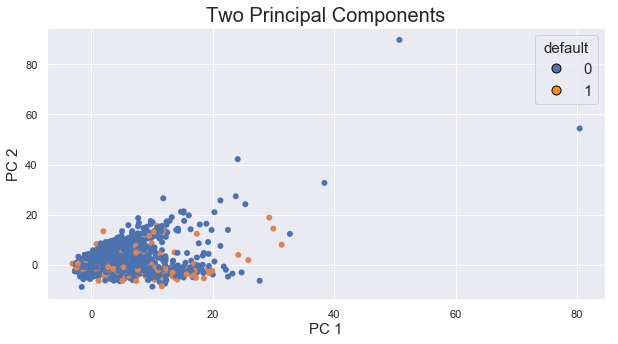

In [35]:
pca = PCA(n_components=2)
X_PCA = pd.concat([pd.DataFrame(pca.fit_transform(X)), dat["default.payment.next.month"]], axis=1)

plt.figure(figsize=(10,5))
plt.rcParams.update({'font.size': 15})
sns.scatterplot(x=0, y=1, hue="default.payment.next.month", data=X_PCA, linewidth=0)
plt.title('Two Principal Components', fontsize=20)
plt.xlabel('PC 1', fontsize=15)
plt.ylabel('PC 2', fontsize=15)
legend_elements = [Line2D([0], [0], marker='.', color='none', label='0',
                          markerfacecolor='b', markersize=18),
                   Line2D([0], [0], marker='.', color='none', label='1',
                          markerfacecolor='darkorange', markersize=18)]
plt.legend(handles=legend_elements, title="default", fontsize=15);

### Visualizing Data with Three Principal Components
The addition of another dimension increases the presence of distinct clusters. Perhaps k nearest neighbor would perform well on this data. Again the plot is misleading because we do not know which clients default after next month.

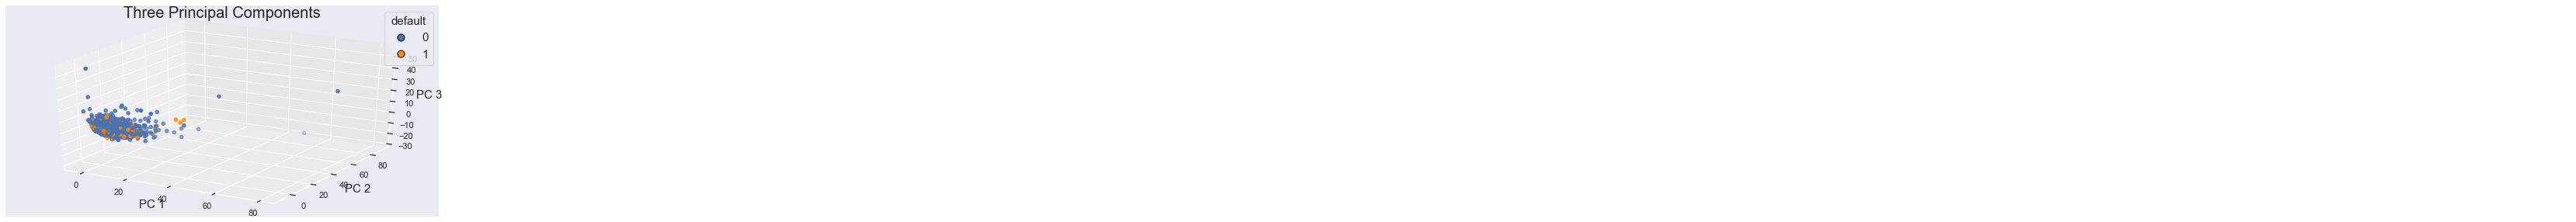

In [36]:
%matplotlib inline
pca = PCA(n_components=3)
X_PCA = pd.concat([pd.DataFrame(pca.fit_transform(X)), dat["default.payment.next.month"]], axis=1)

plt.rcParams.update({'font.size': 15})
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111, projection='3d')
color=np.array(["b", "darkorange"])
ax.scatter(X_PCA[0], X_PCA[1], X_PCA[2], c=color[X_PCA["default.payment.next.month"]], marker='o')
plt.title('Three Principal Components', fontsize=20)
ax.set_xlabel('PC 1', fontsize=15)
ax.set_ylabel('PC 2', fontsize=15)
ax.set_zlabel('PC 3', fontsize=15)
ax.legend(handles=legend_elements, title="default", fontsize=15);

## Utility Functions
Below, we will define a function that compares two scores. This will be used later to compare model accuracy to a baseline accuracy that we will establish in the future. We will also define a function that prints some confusion matrix metrics. Additionally, we will define a function to plot learning curves given an estimator. The plot_learning_curve function was retrieved from SkLearn's documentation / example at: http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html.

In [277]:
def compare_baseline(score, baseline):
    print("Score > Baseline?: {}".format(str(score > baseline).upper()))
    
def cnf_matrix_breakdown(cnf_matrix, score):
    print("\tPredicted 0\tPredicted 1")
    print("True 0\t{}\t\t{}".format(cnf_matrix[0][0], cnf_matrix[0][1]))
    print("True 1\t{}\t\t{}".format(cnf_matrix[1][0], cnf_matrix[1][1]))
    
def print_cross_val_score(estimator, X, y):
    print("\nCross Validated Scores:")
    print("Accuracy: ", np.mean(cross_val_score(estimator, X, y, cv=5, scoring="accuracy")))
    print("Precision: ", np.mean(cross_val_score(estimator, X, y, cv=5, scoring="precision")))
    print("Recall: ", np.mean(cross_val_score(estimator, X, y, cv=5, scoring="recall")))
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,5))
    plt.title(title, fontsize=20)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples", fontsize=15)
    plt.ylabel("Score", fontsize=15)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
   
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best", fontsize=15)
    return plt

def plot_roc_curve(fpr, tpr, col, label=None):
    plt.plot(fpr, tpr, linewidth=3, label=label, color=col)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.title("ROC Curve", fontsize=20)
    
def plot_precision_recall_curve(y, y_scores, col):
    precision, recall, _ = precision_recall_curve(y, y_scores)

    step_kwargs = ({'step': 'post'}
        if 'step' in signature(plt.fill_between).parameters
        else {})
    plt.step(recall, precision, color=col, alpha=0.5, where='post', linewidth=3)
    plt.fill_between(recall, precision, alpha=0.5, color=col, **step_kwargs)

    plt.xlabel('Recall', fontsize=15)
    plt.ylabel('Precision', fontsize=15)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall Curve', fontsize=20);

## Establishing A Baseline
In the context of our data, we are trying to predict whether or not an individual is going to default on his or her next payment. In this case, predicting someone is <b>not going to default</b> on his or her payment and having the individual default is <i>more</i> costly than vice versa. While the true probability of defaulting is unknown, from a risk management perspective the bank should be conservative in predicting no loss to the bank. This is worth taking into account for our blind prediction, and misclassified examples for our future models.  
However, to determine the relative effectiveness of our models, we must first establish a baseline accuracy. We will do this below by observing what percent the majority class makes up in the data. If we just predict the majority class all the time, our accuracy will be equivalent to whatever the majority class percentage is on our training data. Assuming our training data is relatively representative of the entirety of unseen data, we can use this blind prediction as a baseline accuracy that our models should aim to surpass.

In [38]:
BASELINE_ACCURACY = sum(dat['default.payment.next.month'] == 0) / len(dat)

print("Percentage of 0's (individual did NOT default): {}".format(BASELINE_ACCURACY))

Percentage of 0's (individual did NOT default): 0.77944


From the output above, our training data consists of about 78% of class 0, or 'did not default.' We will establish this as a `BASELINE_ACCURACY` variable, for future comparisons. In general, we want our models to be above this baseline.

## Naive Bayes Classifier
Our first classifier is Naive Bayes which requires no hyperparameter tuning. It is a famous learning algorithm that can train and predict efficiently. This algorithm is accurate even when there is not plenty of data to train from.
### Utilizing Naive Bayes for Forward Selection
For this particular forward selection algorithm we are using accuracy times recall as our score. Using this kind of score will force the algorithm to select features that maximize accuracy and recall which is exactly what we want.

In [283]:
remaining_features = list(range(X.shape[1]))
naive_bayes_features = []
best_feature = 0
best_score = 0
prev_score = -1

for i in range(X.shape[1]):
    for j in remaining_features:
        gnb = GaussianNB()
        recall = np.mean(cross_val_score(gnb, X[naive_bayes_features + [j]], y, cv=5, scoring="recall"))
        score = np.mean(cross_val_score(gnb, X[naive_bayes_features + [j]], y, cv=5, scoring="accuracy")) * recall
        if(score > best_score):
            best_feature = j
            best_score = score   
    if(best_score <= prev_score):
        break
        
    naive_bayes_features.append(best_feature)
    remaining_features.remove(best_feature)
    prev_score = best_score
    print(best_score)

print("Best features: ", naive_bayes_features)

Best features:  [18, 39, 37, 38, 61, 17, 0, 15, 3]


Unfortunately, forward selection with Naive Bayes did not select any of our derived features. However, this process has reduce the complexity of our model which will hopefully reduce the chance of overfitting. Let us observe how the model performs with all the features compared to with the selected features. 

### Classifying with All Features

In [76]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

naive_bayes_y_pred = naive_bayes.predict(X_test)
naive_bayes_score = naive_bayes.score(X_test, y_test)
naive_bayes_cnf = confusion_matrix(y_test, naive_bayes_y_pred)

cnf_matrix_breakdown(naive_bayes_cnf, naive_bayes_score)
compare_baseline(naive_bayes_score, BASELINE_ACCURACY)

print_cross_val_score(naive_bayes, X, y)

	Predicted 0	Predicted 1
True 0	5520		352
True 1	1098		530
Score > Baseline?: TRUE

Cross Validated Scores:
Accuracy:  0.8072805673920908
Precision:  0.6179461291788174
Recall:  0.3416692969304821


Naive Bayes with all the features is fairly accurate and precise, but way too many clients in the positive class are being misclassified.

### Classifying with Selected Features

In [77]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train[naive_bayes_features], y_train)

naive_bayes_y_pred = naive_bayes.predict(X_test[naive_bayes_features])
naive_bayes_score = naive_bayes.score(X_test[naive_bayes_features], y_test)
naive_bayes_cnf = confusion_matrix(y_test, naive_bayes_y_pred)

cnf_matrix_breakdown(naive_bayes_cnf, naive_bayes_score)
compare_baseline(naive_bayes_score, BASELINE_ACCURACY)

print_cross_val_score(naive_bayes, X[naive_bayes_features], y)

	Predicted 0	Predicted 1
True 0	3808		2064
True 1	503		1125
Score > Baseline?: FALSE

Cross Validated Scores:
Accuracy:  0.684165255943241
Precision:  0.3816914218407971
Recall:  0.6626548567821352


So we see about a 12% drop in accuracy, a 23% drop in precision and a 32% boost in recall when using the selected features. Since we care way more about false negative rate, the boost in recall justifies the use of these selected.

### Learning Curve for Naive Bayes with Selected Features

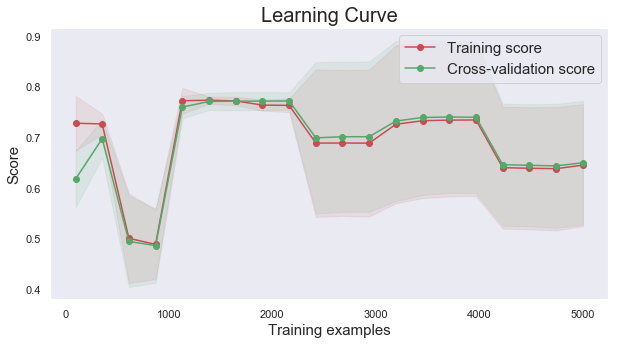

In [127]:
training_data_sizes = np.linspace(start=100, stop=5000, num=20, endpoint=True, dtype=np.int64)
plot_learning_curve(naive_bayes, "Learning Curve", X_train[naive_bayes_features], y_train,cv=10,train_sizes=training_data_sizes);

The learning curve shows that our Naive Bayes model may be underfitting the data since the training curve and cross-validation curve are so close together and below the baseline we established of 77%.

### ROC Curve comparing Naive Bayes Models

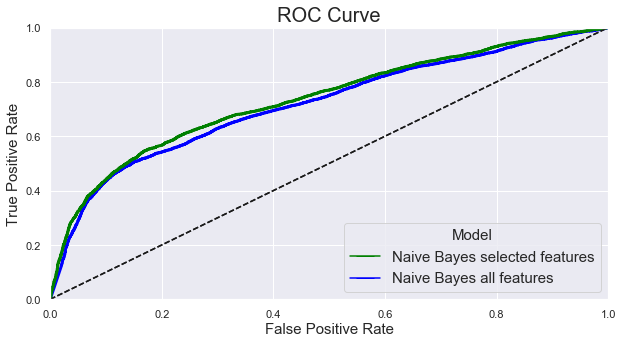

In [83]:
fig = plt.figure(figsize=(10,5))

nb_y_scores = cross_val_predict(naive_bayes, X, y, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, nb_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="blue")

nb_selected_y_scores = cross_val_predict(naive_bayes, X[naive_bayes_features], y, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, nb_selected_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="green")

legend_elements = [Line2D([0], [0], marker='_', color='green', label='Naive Bayes selected features',
                          markerfacecolor='green', markersize=18),
                   Line2D([0], [0], marker='_', color='blue', label='Naive Bayes all features',
                          markerfacecolor='blue', markersize=18)]
plt.legend(handles=legend_elements, title="Model", fontsize=15);

From the ROC curve we can see that Naive Bayes with selected features obtains a greater true positive rate than Naive Bayes with all features, given the two models have the same false positive rates.

### Precision-Recall Curve comparing Naive Bayes Models

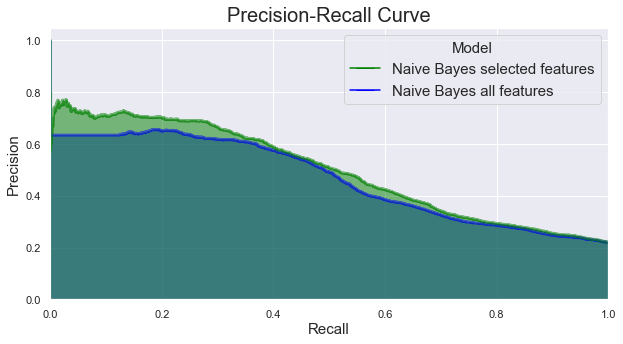

In [91]:
fig = plt.figure(figsize=(10,5))

plot_precision_recall_curve(y, nb_y_scores[:,1], "blue")
plot_precision_recall_curve(y, nb_selected_y_scores[:,1], "green")

legend_elements = [Line2D([0], [0], marker='_', color='green', label='Naive Bayes selected features',
                          markerfacecolor='green', markersize=18),
                   Line2D([0], [0], marker='_', color='blue', label='Naive Bayes all features',
                          markerfacecolor='blue', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

From the precision-recall curve we can see that using selected features with Naive Bayes imporves classification performance.<br>
<br>The performance of Naive Bayes with selected features will serve as another baseline the following models. We will continue to compare ROC and precision-recall curves to help us select the best model for predicting if a client will default next month.

## Logistic Regression
The next model we will evaluate is Logistic Regression. Of course parameter tuning is required to get the best performance out of this algorithm. We supply `recall_score` to `GridSearchCV` get the paramters that optimize recall.
### Grid Search of Hyperparameters

In [152]:
hyperparameters = [{'solver': ['liblinear'], 'penalty': ['l1', 'l2']},
                    {'solver': ['newton-cg'], 'penalty': ['l2']},
                    {'solver': ['sag'], 'penalty': ['l2']},
                    {'solver': ['saga'], 'penalty': ['l1', 'l2']},
                    {'solver': ['lbfgs'], 'penalty': ['l2']}]

grid_search = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0, scoring=make_scorer(recall_score))

pca = PCA(n_components=10)
X_PCA = pd.concat([pd.DataFrame(pca.fit_transform(X)), dat["default.payment.next.month"]], axis=1)
best_model = grid_search.fit(X_PCA, y)

print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best Solver:', best_model.best_estimator_.get_params()['solver'])

Best Penalty: l1
Best Solver: liblinear


Now let us compare Logistic Regression with defaut paramters to Logistic Regression with tuned paramters.

### Classifiying with Not Tuned Paramteres

In [265]:
logistic = LogisticRegression(class_weight="balanced")

logistic.fit(X_train, y_train)
logistic_y_pred = logistic.predict(X_test)
logistic_score = logistic.score(X_test, y_test)
logistic_cnf = confusion_matrix(y_test, logistic_y_pred)

cnf_matrix_breakdown(logistic_cnf, logistic_score)
compare_baseline(logistic_score, BASELINE_ACCURACY)

print_cross_val_score(logistic, X, y)

	Predicted 0	Predicted 1
True 0	4871		1001
True 1	697		931
Score > Baseline?: FALSE

Cross Validated Scores:
Accuracy:  0.7702795882479835
Precision:  0.4830303613014534
Recall:  0.5814258424063723


### Classifying with Tuned Paramters

In [267]:
logistic = LogisticRegression(solver="liblinear", penalty='l1', class_weight={0: 0.1715, 1: 0.8285})

logistic.fit(X_train, y_train)
logistic_y_pred = logistic.predict(X_test)
logistic_score = logistic.score(X_test, y_test)
logistic_cnf = confusion_matrix(y_test, logistic_y_pred)

cnf_matrix_breakdown(logistic_cnf, logistic_score)
compare_baseline(logistic_score, BASELINE_ACCURACY)

print_cross_val_score(logistic, X, y)

	Predicted 0	Predicted 1
True 0	4207		1665
True 1	515		1113
Score > Baseline?: FALSE

Cross Validated Scores:
Accuracy:  0.7018798111503924
Precision:  0.3980855325706847
Recall:  0.6858865361421499


Using the tuned paramters allowed Logistic Regression to score better than Naive Bayes in accuracy, precision, and recall. This is fantastic, and since Logistic Regression performs regularization we dont have to worry about selecting features.

### Learning Curve for Tuned Logistic Regression

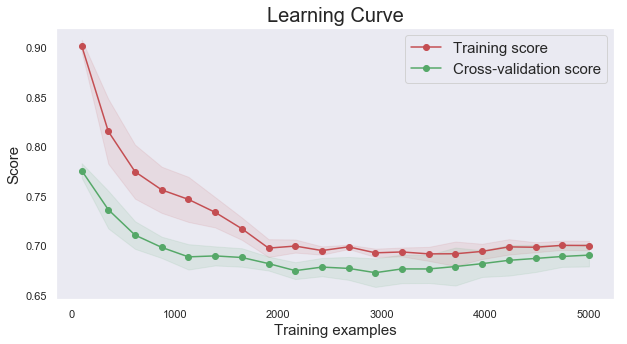

In [163]:
training_data_sizes = np.linspace(start=100, stop=5000, num=20, endpoint=True, dtype=np.int64)
plot_learning_curve(logistic, "Learning Curve", X_train, y_train, cv=10, train_sizes=training_data_sizes);

The curves are for training and cross validation are close to eachother so the model doesnt seem to be overfitting. Increasing the amount of data does not seem appear to improve the accuracy which is only a little less than the 77% baseline.

### ROC Curve comparing Logistic Regression and Naive Bayes

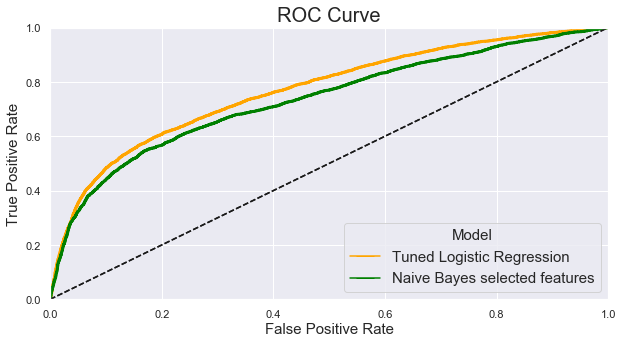

In [288]:
fig = plt.figure(figsize=(10,5))

lg_y_scores = cross_val_predict(logistic, X, y, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(y, lg_y_scores)
plot_roc_curve(fpr, tpr, col="orange")

nb_y_scores = cross_val_predict(naive_bayes, X[naive_bayes_features], y, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, nb_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="green")

legend_elements = [Line2D([0], [0], marker='_', color='orange', label='Tuned Logistic Regression',
                          markerfacecolor='green', markersize=18),
                   Line2D([0], [0], marker='_', color='green', label='Naive Bayes selected features',
                          markerfacecolor='blue', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

### Precision Recall Curve comparing Logistic Regression and Naive Bayes

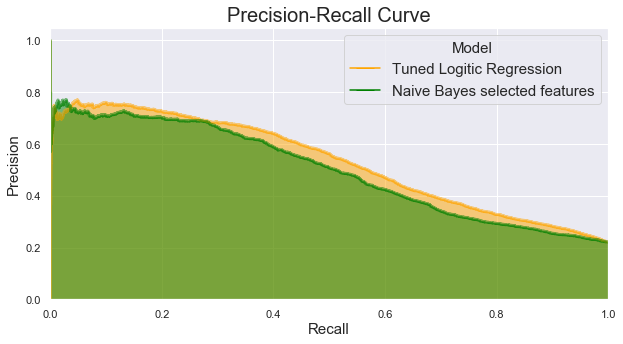

In [289]:
fig = plt.figure(figsize=(10,5))

plot_precision_recall_curve(y, lg_y_scores, "orange")
plot_precision_recall_curve(y, nb_y_scores[:,1], "green")

legend_elements = [Line2D([0], [0], marker='_', color='orange', label='Tuned Logitic Regression',
                          markerfacecolor='green', markersize=18),
                   Line2D([0], [0], marker='_', color='green', label='Naive Bayes selected features',
                          markerfacecolor='blue', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

From these plots it is clear that Logistic Regression performs better than Naive Bayes.

## Support Vector Classifier
The next classifier we will look at for our data is a support vector machine, using the SVC from SkLearn. As we observed above, the blind prediction is our baseline and we are aiming for our models to surpass this. To start, we will use a simple SVC with some tuning to see how it performs. We will compare one SVC using all features, and one using the features from Naive Bayes.

In [198]:
simple_svc = SVC(gamma='scale',  class_weight={0: 0.1715, 1: 0.8285})
simple_svc = simple_svc.fit(X_train, y_train)

simple_svc_y_pred = simple_svc.predict(X_test)
simple_svc_score = simple_svc.score(X_test, y_test)
svc_cnf = confusion_matrix(y_test, simple_svc_y_pred)

cnf_matrix_breakdown(svc_cnf, simple_svc_score)
compare_baseline(simple_svc_score, BASELINE_ACCURACY)

print_cross_val_score(simple_svc, X, y)

	Predicted 0	Predicted 1
True 0	4261		1611
True 1	539		1089
Score > Baseline?: FALSE

Cross Validated Scores:
Accuracy:  0.7001203230608131
Precision:  0.3969499210590489
Recall:  0.6907829331981907


So it seems our default SVC has an accuracy less than our baseline, but not by a significant amount. We also have a low number of false positives. As discussed before, false positives are more important for us to get right, because they are a greater risk to the bank. Before we try something else to increase the performance of our SVC, let's look at a learning curve. Because training an SVC is computationally costly, we will use fairly large intervals of training data size. Note that we will be using cross-validation in this learning curve.

### Learning Curve for SVC

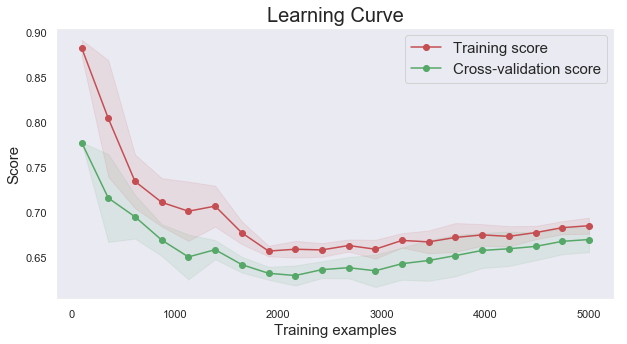

In [195]:
training_data_sizes = np.linspace(start=100, stop=5000, num=20, endpoint=True, dtype=np.int64)
plot_learning_curve(simple_svc, "Learning Curve", X_train, y_train, cv=10, train_sizes=training_data_sizes);

From this learning curve, we can see training score and the cross validation score decrease steadily with each other. This is less optimal than what we would want, given our accuracy is below the baseline of 78%. The curves are close to each other, which appears to discredit a high variance scenario. Given that we have a large number of features, it's possible we are perhaps overfitting, though the learning curve does not seem to suggest this, which is somewhat strange.

### ROC Curve comparing Logistic Regression and SVC

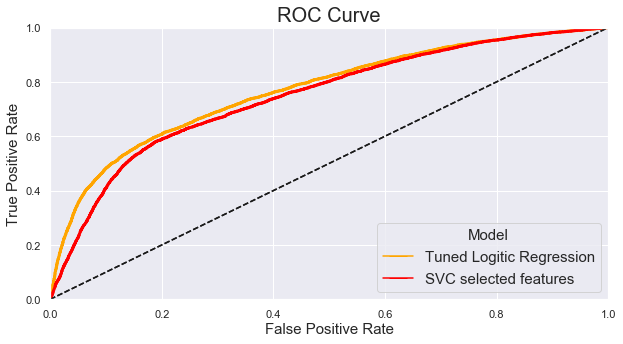

In [193]:
simple_svc = SVC(gamma='scale',  class_weight={0: 0.1715, 1: 0.8285}, probability=True)

fig = plt.figure(figsize=(10,5))

lg_y_scores = cross_val_predict(logistic, X, y, cv=5, method="decision_function")
fpr, tpr, thresholds = roc_curve(y, lg_y_scores)
plot_roc_curve(fpr, tpr, col="orange")

svc_y_scores = cross_val_predict(simple_svc, X, y, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, svc_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="red")

legend_elements = [Line2D([0], [0], marker='_', color='orange', label='Tuned Logitic Regression',
                          markerfacecolor='orange', markersize=18),
                   Line2D([0], [0], marker='_', color='red', label='SVC selected features',
                          markerfacecolor='red', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

### Precision Recall Curve comparing Logistic Regression and SVC

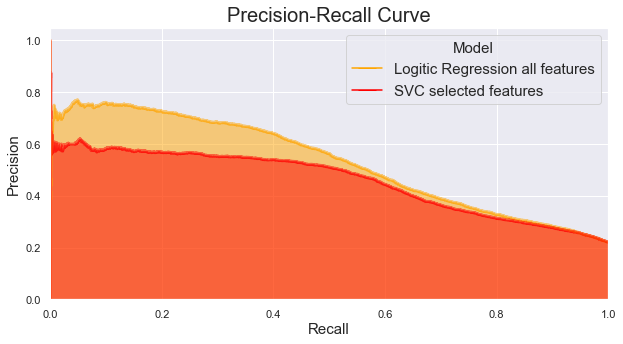

In [197]:
fig = plt.figure(figsize=(10,5))

plot_precision_recall_curve(y, lg_y_scores, "orange")
plot_precision_recall_curve(y, svc_y_scores[:,1], "red")

legend_elements = [Line2D([0], [0], marker='_', color='orange', label='Logitic Regression all features',
                          markerfacecolor='orange', markersize=18),
                   Line2D([0], [0], marker='_', color='red', label='SVC selected features',
                          markerfacecolor='red', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

From these plots it is clear that Logistic Regression performs better than SVC.

## Utilizing Random Forests for Feature Importance
Since training and predicting with an SVC is very costly (approximately O(m^2 * n) according to SkLearn's documentation), we will attempt to use Random Forests for two things. The first is as a classifier itself, and the second is for feature importance. We will use this feature importance to implement forward selection on SVC, as well as attempt to reduce potential overfitting-- as we are currently using 90 features. 

In [183]:
simple_random_forest = RandomForestClassifier(random_state=831)
simple_random_forest.fit(X_train, y_train)

simple_rfc_pred = simple_random_forest.predict(X_test)
simple_rfc_score = simple_random_forest.score(X_test, y_test)
simple_rfc_cnf = confusion_matrix(y_test, simple_rfc_pred)

cnf_matrix_breakdown(simple_rfc_cnf, simple_rfc_score)
compare_baseline(simple_rfc_score, BASELINE_ACCURACY)

print_cross_val_score(simple_random_forest, X, y)

	Predicted 0	Predicted 1
True 0	5522		350
True 1	1104		524
Score > Baseline?: TRUE

Cross Validated Scores:
Accuracy:  0.8034799008031961
Precision:  0.6050177774141329
Recall:  0.31573945336345516


While the accuracy achieved with the default hyperparameters is greater than our baseline, it isn't by much. We'll look at the learning curve of the default random forest classifier before observing what the classifier says about feature importance, and then we'll utilize grid search to try and improve this classifier.

### Learning Curve of the Random Forest Classifier

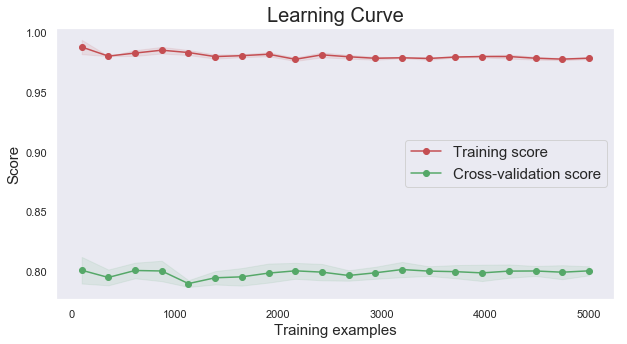

In [176]:
training_data_sizes = np.linspace(start=100, stop=5000, num=20, endpoint=True, dtype=np.int64)
plot_learning_curve(simple_random_forest, "Learning Curve", X_train, y_train, cv=10, train_sizes=training_data_sizes);

As you can see above, the curves are very far apart, indicating high variance. Our training score is nearing 100% accuracy in fact, but our cross validation score is nearing worse than baseline. To help reduce this problem, we are going to observe the `feature_importances_` object that is generated when training the random forest. We'll use this as a preliminary way of doing feature selection. Along with this, we'll incorporate forward selection and observe the results.

### Feature Importances
Below, we will observe the feature importances as generated by the random forest classifier.

In [177]:
feature_importances = pd.DataFrame(simple_random_forest.feature_importances_, columns=['importance']).sort_values(
    'importance', ascending=False)
feature_importances.head(10)

,importance
39,0.059416
1,0.047345
0,0.045788
18,0.040520
14,0.039142
19,0.038098
2,0.036887
4,0.034909
16,0.034717
15,0.033434


Previously in the report, we derived some features using linear coefficients from the time series data. As shown above, all four of these features are present in the most important features (columns 90-93) as determined by this random forest classifier. Before we perform any feature selection and recreate our SVC, let's utilize grid search to fine tune our random forest, and see if the feature importances change at all with a better random forest.

### Using Grid Search on the Random Forest

In [ ]:
parameter_grid = [
    {'n_estimators': [50, 100, 500], 
     'max_depth': [1, 5, None], 
     'max_features': ['sqrt', 'log2'], 
     'oob_score':[True, False]}
]

tuned_random_forest = RandomForestClassifier(random_state=831)
rfc_search = GridSearchCV(tuned_random_forest, parameter_grid, cv=5)

rfc_search.fit(X_train, y_train)

With this grid search object, we will observe the best parameters and construct a new random forest classifier using them, and observe feature importances again, as well as accuracy metrics from the models themselves.

In [ ]:
rfc_search.best_params_

### Making A Tuned Random Forest

In [184]:
tuned_random_forest = RandomForestClassifier(n_estimators=500, max_depth=None, oob_score=True, random_state=831)
tuned_random_forest.fit(X_train, y_train)

tuned_rfc_predict = tuned_random_forest.predict(X_test)
tuned_rfc_score = tuned_random_forest.score(X_test, y_test)
tuned_rfc_cnf = confusion_matrix(y_test, tuned_rfc_predict)

cnf_matrix_breakdown(tuned_rfc_cnf, tuned_rfc_score)
compare_baseline(tuned_rfc_score, BASELINE_ACCURACY)

print_cross_val_score(tuned_random_forest, X, y)

	Predicted 0	Predicted 1
True 0	5507		365
True 1	1037		591
Score > Baseline?: TRUE

Cross Validated Scores:
Accuracy:  0.8153601410432056
Precision:  0.6450857509021273
Recall:  0.3623513170646627


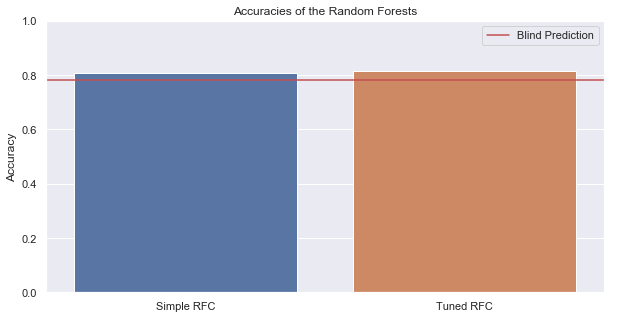

In [286]:
fig = plt.figure(figsize=(10,5))
sns.barplot(['Simple RFC', 'Tuned RFC'], [simple_rfc_score, tuned_rfc_score])
plt.axhline(y=BASELINE_ACCURACY, color='r', linestyle='-', label='Blind Prediction')
plt.ylim((0, 1.0))
plt.ylabel('Accuracy')
plt.title('Accuracies of the Random Forests')
plt.legend()
plt.show()

So, we see a marginal increase, but marginal is better than none. We also see a slight decrease in the false negative rate, which is extremely preferable in this case.

Next, we'll look at the new feature importances and observe if they differ from the default random forest's.

In [185]:
feature_importances2 = pd.DataFrame(tuned_random_forest.feature_importances_, columns=['importance']).sort_values(
    'importance', ascending=False)

feature_importances2.head(10)

,importance
1,0.047812
39,0.046651
0,0.046357
18,0.041899
14,0.037124
19,0.036214
17,0.036042
15,0.035049
2,0.034279
16,0.033337


Observing the indices, which represent the most important features, they are as follows:  

Default RFC: `[39, 1, 0, 18, 14, 19, 2, 4, 16, 15]`  
Tuned RFC:   `[1, 39, 0, 18, 19, 14, 17, 15, 2, 16]`

It seems both the random forests agree that columns 1, 0 and 31 are the three most important features. We will be using the tuned RFCs feature importances for forward selection in the next sections.

### Forward Selection on the Random Forest Classifier
We may be getting ~.81 accuracy with the current set of features, but as our learning curve showed, we have a high variance situation. To help reduce this, we will perform feature selection by using the feature importances data we just obtained. We will use up to 25 features. This is not necessarily the kosher form of forward selection, as forward selection would involve finding the first best feature, and then the subsequent best features in combination with the previous ones. But in the interest of computational time, we'll use random forest's given feature importances object.

In [190]:
feature_selection_rfc = RandomForestClassifier(n_estimators=500, max_depth=None, oob_score=True, random_state=831)
scores = []
false_positives = []
num_features = [i for i in range(1, 26)]

for i in num_features:
    features_used = list(feature_importances.index[0:i])
    
    # Train model with subset of features.
    feature_selection_rfc.fit(X_train[features_used], y_train)
    
    # Get predictions and scores
    ft_selection_rfc_predict = feature_selection_rfc.predict(X_test[features_used])
    scores.append(feature_selection_rfc.score(X_test[features_used], y_test))
    
    # Get # of false negatives
    cnf_matrix = confusion_matrix(y_test, ft_selection_rfc_predict)
    false_positives.append(cnf_matrix[1][0])

### Accuracy by Number of 'Best' Features Used

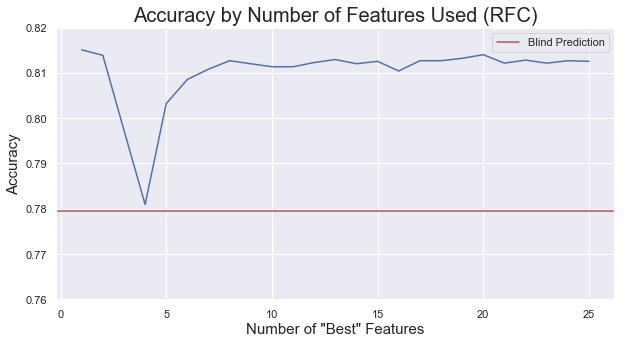

In [285]:
fig = plt.figure(figsize=(10,5))

plt.plot(num_features, scores)
plt.xlabel('Number of "Best" Features', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.title('Accuracy by Number of Features Used (RFC)', fontsize=20)
plt.axhline(y=BASELINE_ACCURACY, color='r', linestyle='-', label='Blind Prediction')
plt.ylim((0.76, 0.82))

plt.legend()
plt.show()

### False Negatives by Number of 'Best' Features Used

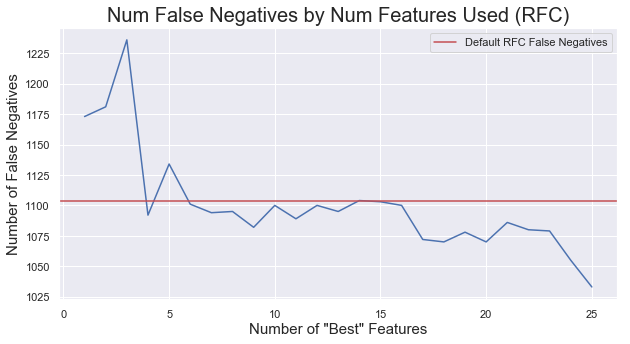

In [284]:
fig = plt.figure(figsize=(10,5))

plt.plot(num_features, false_positives)
plt.xlabel('Number of "Best" Features', fontsize=15)
plt.ylabel('Number of False Negatives', fontsize=15)
plt.title('Num False Negatives by Num Features Used (RFC)', fontsize=20)
plt.axhline(y=simple_rfc_cnf[1][0], color='r', linestyle='-', label='Default RFC False Negatives')

plt.legend()
plt.show()

In both of the plots above, we observe a fairly clear elbow effect on the curves. This plateau typically happens around 7 or 8 best features being used, and from there no significant improvement is made up to 25 features. The max accuracy achieved was about .815, which is only very marginally better than the tuned random forest with all the features.

### ROC Curve comparing Logitic Regression and Random Forest Models

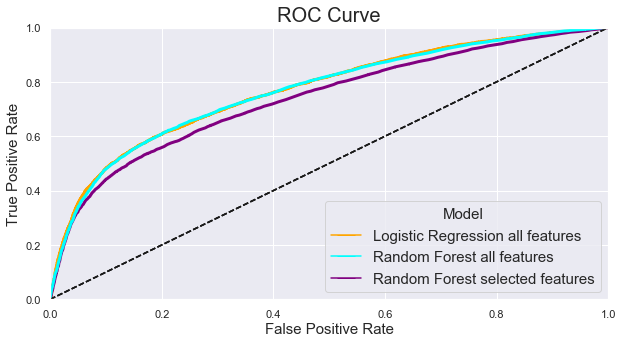

In [261]:
fig = plt.figure(figsize=(10,5))

lg_y_scores = cross_val_predict(logistic, X, y, cv=5, method='predict_proba')
fpr, tpr, thresholds = roc_curve(y, lg_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="orange")

rf_selected_y_scores = cross_val_predict(tuned_random_forest, X[[1, 39, 0, 18, 19, 14, 17, 15]], y, cv=5, method="predict_proba")
fpr, tpr, thresholds = roc_curve(y, rf_selected_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="purple")

rf_y_scores = cross_val_predict(tuned_random_forest, X, y, cv=5, method="predict_proba")
fpr, tpr, thresholds = roc_curve(y, rf_y_scores[:,1])
plot_roc_curve(fpr, tpr, col="cyan")

legend_elements = [Line2D([0], [0], marker='_', color='orange', label='Logistic Regression all features',
                          markerfacecolor='orange', markersize=18),
                   Line2D([0], [0], marker='_', color='cyan', label='Random Forest all features',
                          markerfacecolor='cyan', markersize=18),
                  Line2D([0], [0], marker='_', color='purple', label='Random Forest selected features',
                          markerfacecolor='purple', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

### Precision-Recall Curve comparing Logitic Regression and Random Forest Models

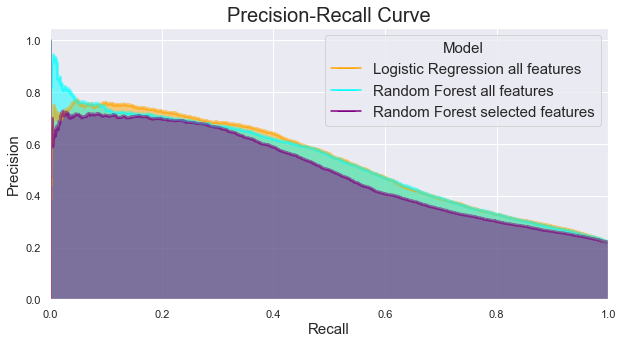

In [280]:
fig = plt.figure(figsize=(10,5))

plot_precision_recall_curve(y, lg_y_scores[:,1], "orange")
plot_precision_recall_curve(y, rf_y_scores[:,1], "cyan")
plot_precision_recall_curve(y, rf_selected_y_scores[:,1], "purple")

legend_elements = [Line2D([0], [0], marker='_', color='orange', label='Logistic Regression all features',
                          markerfacecolor='orange', markersize=18),
                   Line2D([0], [0], marker='_', color='cyan', label='Random Forest all features',
                          markerfacecolor='cyan', markersize=18),
                  Line2D([0], [0], marker='_', color='purple', label='Random Forest selected features',
                          markerfacecolor='purple', markersize=18)]

plt.legend(handles=legend_elements, title="Model", fontsize=15);

From these plots it appears that Logistic Regression performs better than Random Forest.

## Our Final Model
When considering what model we are going to choose for our final predictive model, we are not only going to consider accuracy, but recall. As we stated before in the report, false negatives are more costly to us in the context of risk management. Predicting that a client is not going to default and then having them default ends up losing the bank more money in the long run. The client builds up debt and the bank must sell off the remaining debt to a collection agency for a fraction of what the client owed, and the bank takes some loss. When we choose our model, we want to take into account both accuracy and minimizing the number of false negatives. Because of this, our model may have only slightly better than blind accuracy (or perhaps even lower) but the real world impact of minimizing false negatives will be overall better than simply a high accuracy alone.

For our final model, we are going to use a logistic regression model, tuned to prioritize recall. Please place a test dataset filepath in the cell below.

#### Place Data Below

In [ ]:
# Please enter a filepath here and then run the cell. This cell may take a
# few minutes to run because of the feature derivation and training the model.
#-------------------------------------------------------------------------------
test_data_path = "YOUR_FILEPATH_HERE"

# Load test data as a dataframe
test_data = pd.read_csv(test_data_path)

# Derive linear coefficients as predictors for bill and pay data.
months = [i for i in range(1,7)]

bill_amt_subset = test_data.iloc[:,[12, 13, 14, 15, 16, 17]]
new_predictors = np.array([])

for index, row in bill_amt_subset.iterrows():
    fit = np.polyfit(months, row, 1)
    
    if new_predictors.size == 0:
        new_predictors = fit
    else:
        new_predictors = np.vstack([new_predictors, fit])
        
bill_amt_coeff = pd.DataFrame(new_predictors, columns=[90, 91])

pay_amt_subset = test_data.iloc[:,[18, 19, 20, 21, 22, 23]]
new_predictors2 = np.array([])

for index, row in pay_amt_subset.iterrows():
    fit = np.polyfit(months, row, 1)
    
    if new_predictors2.size == 0:
        new_predictors2 = fit
    else:
        new_predictors2 = np.vstack([new_predictors2, fit])
        
pay_amt_coeff = pd.DataFrame(new_predictors2, columns=[92, 93])

test_data = pd.concat([test_data, bill_amt_coeff, pay_amt_coeff], axis=1)

# Derive statistical features using bill and pay data.
test_data["pay/bill_amt_mean"] = np.mean(pay_amt_subset.T) / (np.mean(bill_amt_subset.T) + 1)
test_data["pay/bill_amt_sd"] = np.std(pay_amt_subset.T) / (np.std(bill_amt_subset.T) + 1)

test_data["bill*pay_amt_mean"] = np.mean(pay_amt_subset.T) * np.mean(bill_amt_subset.T)
test_data["bill*bill_amt_sd"] = np.mean(pay_amt_subset.T) * np.mean(bill_amt_subset.T)

# Run Preprocessing Pipeline
final_X = pd.DataFrame(np.concatenate((num_pipeline.fit_transform(test_data), cat_pipeline.fit_transform(test_data)), 1))
final_y = test_data['default.payment.next.month']

# Train the Logistic Regression with the all of the data we currently have (X).
# Then, predict on the test_data.
final_model = LogisticRegression(solver="liblinear", penalty='l1', class_weight={0: 0.1715, 1: 0.8285})

final_model.fit(X[logistic_features], y)
final_y_pred = logistic.predict(final_X[logistic_features])
final_score = logistic.score(final_X[logistic_features], final_y)
final_cnf = confusion_matrix(final_y, final_y_pred)

# Metrics of the final model.
cnf_matrix_breakdown(final_cnf, final_score)
compare_baseline(final_score, BASELINE_ACCURACY)

print_cross_val_score(final_model, final_X[logistic_features], final_y)